In [7]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

from ssl_eeg import preprocessing as pr, preprocessing_nback as prn, preprocessing_unlabeled as pru, model, metrics, plot

plt.rcParams["lines.marker"] = ""

In [2]:
def get_session_list(blocks_df, start_ses_from=0, drop_timestamp=False):
    ses = []
    start = pr.s_freq
    blocks = blocks_df.copy()
    if drop_timestamp:
        blocks = blocks_df.drop(columns="time_stamp")

    for g, frame in blocks.groupby(["session_no", "block_no"]):
        if g[1] == 1:
            frame = frame.iloc[start_ses_from:]
        ses.append(frame.to_numpy().T)
    return ses

### Plot frequency

In [5]:
# n-back data
blocks_n = prn.extract_blocks(verbose=False, filter_data=False)
ses_n = get_session_list(blocks_n, drop_timestamp=True)
freqs, psd_n = metrics.get_psds(ses_n)
psd_n_ses_mean = np.mean(psd_n, axis=1)
psd_n_mean = np.mean(psd_n_ses_mean, axis=0)

In [6]:
# unlabeled data
blocks_u = pru.make_blocks_df()
ses_u = get_session_list(blocks_u, start_ses_from=30)
freqs, psd_u = metrics.get_psds(ses_u)
psd_u_ses_mean = np.mean(psd_u, axis=1)
psd_u_mean = np.mean(psd_u_ses_mean, axis=0)

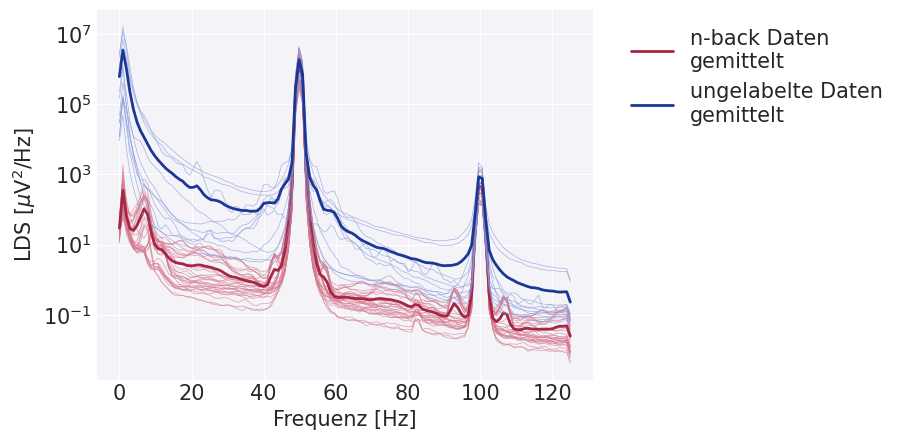

In [13]:
mpl.rcParams["font.size"] = 15
rel_freqs_idx = freqs[freqs <= 130].shape[0]

fig, ax = plt.subplots()
ax.set_xlabel("Frequenz [Hz]")
ax.set_ylabel("LDS [$\mu$V$^2$/Hz]")

for i, sm in enumerate(psd_n_ses_mean):
    ax.semilogy(freqs[:rel_freqs_idx], sm[:rel_freqs_idx], color=plot.n_sec_color, linewidth=0.5, alpha=0.7)

ax.semilogy(freqs[:rel_freqs_idx], psd_n_mean[:rel_freqs_idx], label="n-back Daten\ngemittelt", color=plot.n_main_color, linewidth=2)

for i, sm in enumerate(psd_u_ses_mean):
    ax.semilogy(freqs[:rel_freqs_idx], sm[:rel_freqs_idx], color=plot.u_sec_color, linewidth=0.5, alpha=0.7)

ax.semilogy(freqs[:rel_freqs_idx], psd_u_mean[:rel_freqs_idx], label="ungelabelte Daten\ngemittelt", color=plot.u_main_color, linewidth=2)

ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

In [14]:
plot.save_plot_and_legend(ax, os.path.join(plot.plots_path, "spectrum", "mean_spectrum_labeled_unlabeled"))

### Plot frequency for normalized and filtered chunks

In [42]:
filter = 55

In [43]:
# n-back data
blocks_n = prn.extract_blocks(verbose=False, lowpass=filter, filter_data=True)
chunks_n = prn.make_chunks_df(blocks_n)
chunks_n_data, ns = prn.get_samples_data(chunks_n, blocks_n)
chunks_n_data_norm = pr.normalize_data(chunks_n_data)

freqs, psd_chunks_n = metrics.get_psds(chunks_n_data_norm)
psd_chunks_channels_n_mean = np.mean(psd_chunks_n, axis=0)

In [44]:
# unlabeled data
blocks_u = pru.make_blocks_df()
blocks_u = pru.filter_blocks_df(blocks_u, lowpass=filter, verbose=False)
chunks_u = pru.make_chunks_df(blocks_u)
chunks_u_data = pru.get_samples_data(torch.from_numpy(chunks_u.to_numpy()), torch.from_numpy(blocks_u.to_numpy()).T)
chunks_u_data_norm = pr.normalize_data(chunks_u_data)

freqs, psd_chunks_u = metrics.get_psds(chunks_u_data_norm)
psd_chunks_channels_u_mean = np.mean(psd_chunks_u, axis=0)

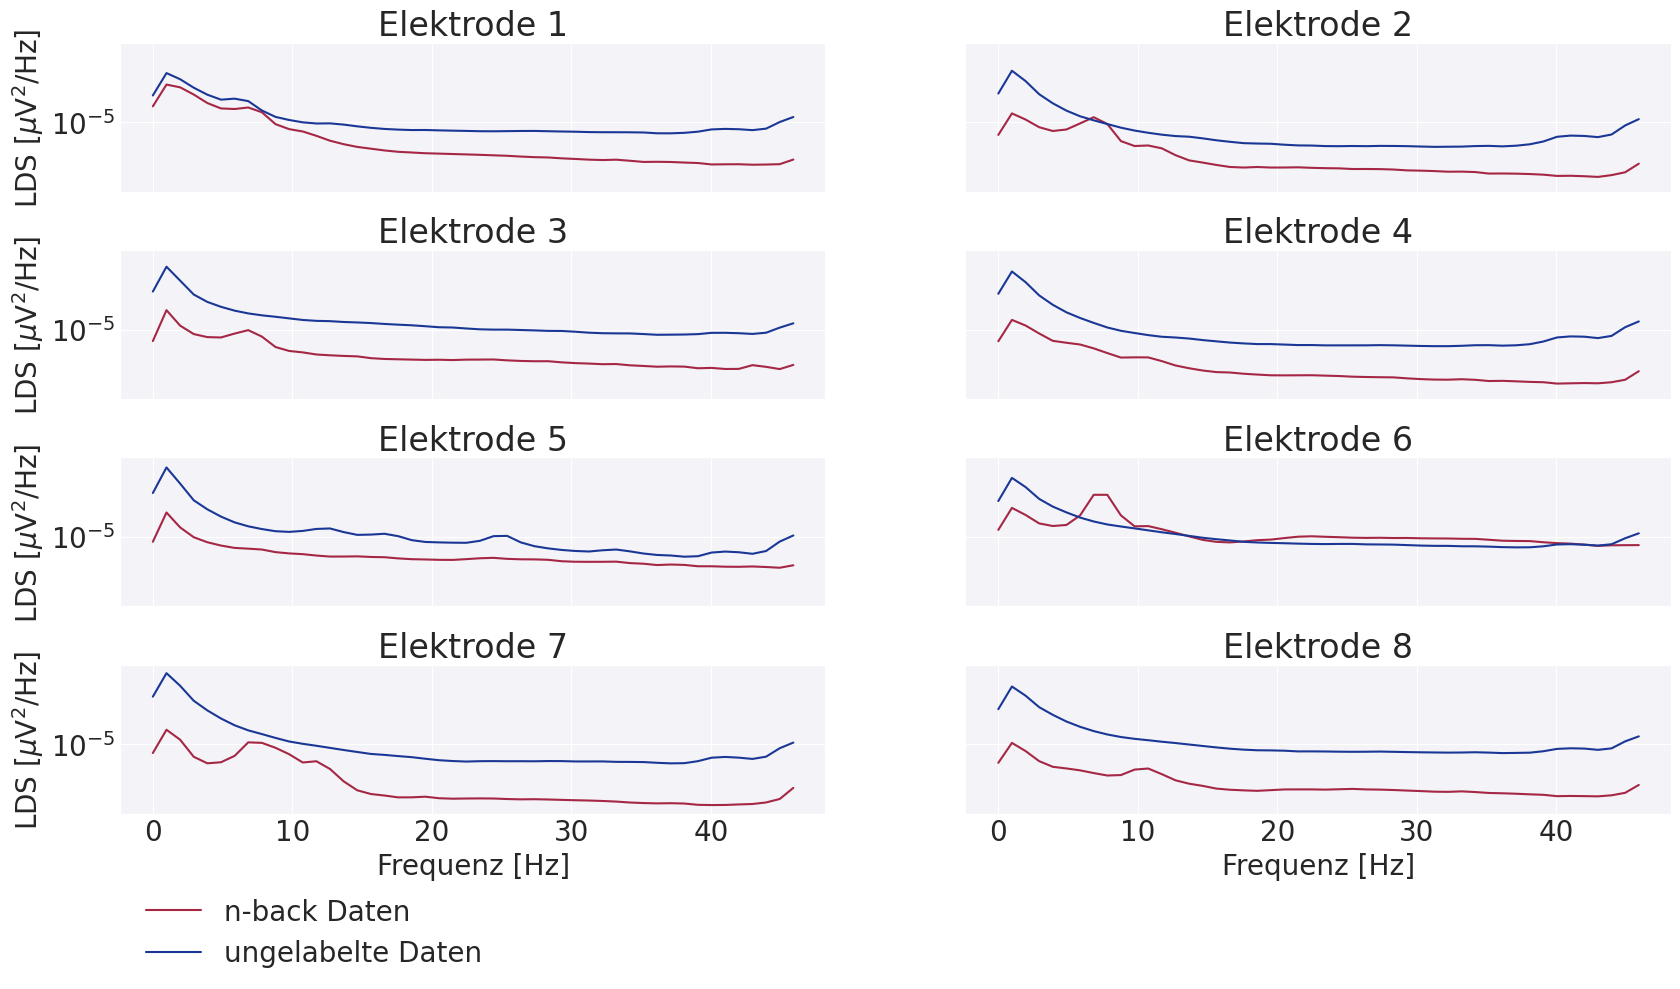

In [45]:
mpl.rcParams["font.size"] = 20
fig, axes = plt.subplots(4,2, figsize=(20,10))
electr = 0
rel_freqs_idx = freqs[freqs <= 46].shape[0]

for row in axes:
    for ax in row:
        electr += 1
        ax.set_title(f"Elektrode {electr}")

        ax.semilogy(freqs[:rel_freqs_idx], psd_chunks_channels_n_mean[electr-1][:rel_freqs_idx], color=plot.n_main_color, label="n-back Daten")
        ax.semilogy(freqs[:rel_freqs_idx], psd_chunks_channels_u_mean[electr-1][:rel_freqs_idx], color=plot.u_main_color, label="ungelabelte Daten")
        
        ax.set_xlabel("Frequenz [Hz]")
        ax.set_ylabel("LDS [$\mu$V$^2$/Hz]")
        if filter == 55:
            ax.set_ylim(10**-7.2, 0.003) # normalized 55Hz
        elif filter == 45:
            ax.set_ylim(10**-5.2, 0.02) # normalized 45Hz
            # ax.set_ylim(0.05, 10**7.5) # not normalized 45 Hz

for ax in axes.flat:
    ax.label_outer()

axes[3,0].legend(bbox_to_anchor=(0, -0.4), loc='upper left')
plt.subplots_adjust(hspace=0.4)

plt.show()

In [46]:
fig.savefig(os.path.join(plot.plots_path, "spectrum", f"chunks_mean_channel_spectrum_{filter}Hz_normalized"), dpi=200, bbox_inches="tight")

### Plot EEG-Channels

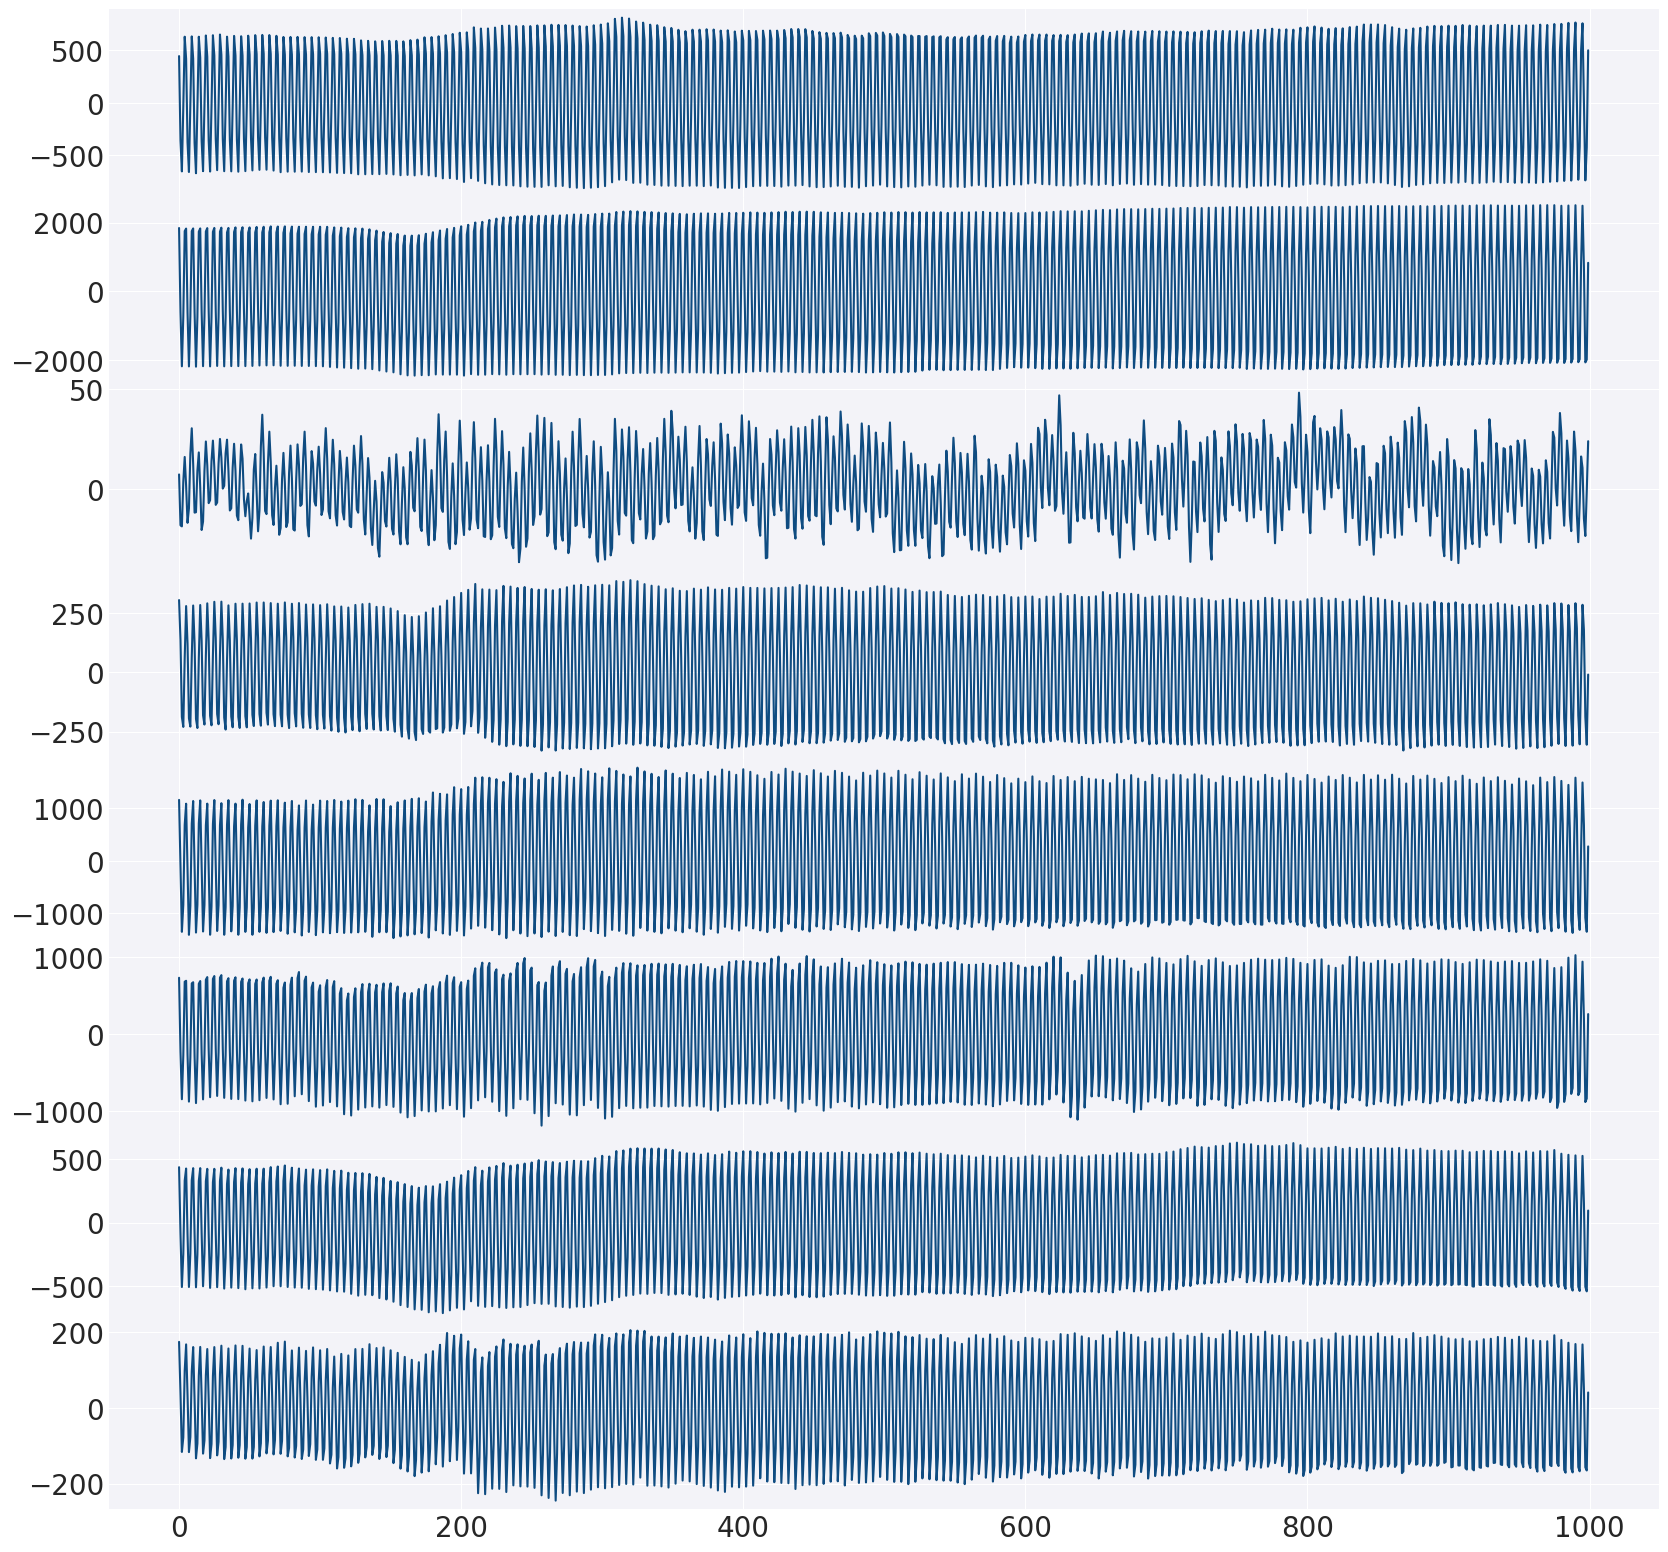

In [53]:
blocks_ses = blocks_u.loc[(blocks_u["session_no"]==9) & (blocks_u["block_no"]==1)]
eeg = blocks_ses.to_numpy()[:,:-2]

start = pr.s_freq * 30
shift = 100000
width = 1000

fig, ax = plt.subplots(8, sharex=True)
fig.set_size_inches(20,15)

for i, c in enumerate(eeg.T):
    ax[i].plot(c[start+shift : start+width+shift])

plt.subplots_adjust(top = 1, bottom=0, hspace=0.0, wspace=0.4)
plt.show()